# Data Cleaning and Engineering

The main goal of this project is to clean [Indicators of Anxiety or Depression Based on Reported Frequency of Symptoms During Last 7 Days](https://catalog.data.gov/dataset/indicators-of-anxiety-or-depression-based-on-reported-frequency-of-symptoms-during-last-7-). Any analysis or machine learning algorithm will depend upon the data being clean. It is a very basic and important assumption that it is common for statisticians to say *Garbage in, Garbage out*.

Any government data is notorious for being unclean. The main goal of this project is simple: prepare this data for further analysis. While I aim to do some exploratory data analysis myself, this won't be the goal of this project.

The main tool of this project will be SQL - specifically the SQLite version. The analysis will then be done in Python.

## Downloading the Data

Due to the size of the original dataset, you have to download it yourself. Run the code below to download the version of the file I used.

In [1]:
import requests
import os

URI = "https://data.cdc.gov/api/views/8pt5-q6wp/rows.csv?accessType=DOWNLOAD"

if not os.path.isfile("data.csv"):
    with requests.get(URI) as request:
        with open("data.csv", "wb") as file:
            file.write(request.content)
            print("Data has been downloaded")
else:
    print("Data is already downloaded")

Data is already downloaded


## Moving the Data to SQLite

Since the tool of choice is SQLite and the data is currently in a CSV file, we need to transform it first. We will use pandas for help with this section.

In [2]:
import pandas as pd
import sqlite3

conn = sqlite3.connect("data.db")

data = pd.read_csv("data.csv")
data.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,Low CI,High CI,Confidence Interval,Quartile Range
0,Symptoms of Depressive Disorder,National Estimate,United States,United States,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.5,22.7,24.3,22.7 - 24.3,NaN
1,Symptoms of Depressive Disorder,By Age,United States,18 - 29 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,32.7,30.2,35.2,30.2 - 35.2,NaN
2,Symptoms of Depressive Disorder,By Age,United States,30 - 39 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,25.7,24.1,27.3,24.1 - 27.3,NaN
3,Symptoms of Depressive Disorder,By Age,United States,40 - 49 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,24.8,23.3,26.2,23.3 - 26.2,NaN
4,Symptoms of Depressive Disorder,By Age,United States,50 - 59 years,1,1,"Apr 23 - May 5, 2020",04/23/2020,05/05/2020,23.2,21.5,25.0,21.5 - 25.0,NaN


In [3]:
data.to_sql("raw_data", conn, if_exists='replace')

12501

## Getting all columns of the data

For the data cleaning and engineering process, we will do this column by column. For that, we will need to get the columns from the dataset.

In [4]:
cur = conn.cursor()
cur.execute("""
    SELECT
        name,
        type
    FROM pragma_table_info('raw_data') AS table_info;
""")

In [5]:
columns = pd.DataFrame(cur.fetchall(), columns=['name', 'type'])
columns.head(15)

,name,type
0,index,INTEGER
1,Indicator,TEXT
2,Group,TEXT
3,State,TEXT
4,Subgroup,TEXT
5,Phase,TEXT
6,Time Period,INTEGER
7,Time Period Label,TEXT
8,Time Period Start Date,TEXT
9,Time Period End Date,TEXT


In [6]:
len(columns)

15

So we have 15 columns to clean. Our final step before actually cleaning is to create a second table named `cleaned_data` so that we are not modifying the original data.

In [7]:
data.to_sql("cleaned_data", conn, if_exists='replace')

12501

## Removing Columns

The first step is to remove columns that are redundant - there are a few here that are so:

1. **Time Period**. This always coincides with Time Period Start Date and Time Period End Date.
2. **Time Period Label**. This is simply a label for Time Period Start Date and Time Period End Date.
3. **Confidence Interval**. This is the text format of Low CI and High CI.

In [8]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    DROP COLUMN 'Time Period';
""")
cur.execute("""
    ALTER TABLE cleaned_data
    DROP COLUMN 'Time Period Label';
""")
cur.execute("""
    ALTER TABLE cleaned_data
    DROP COLUMN 'Confidence Interval';
""")
conn.commit()

## Transforming Date Columns

Let us now transform the date columns. We will first look if each contains 12501 rows since we would first need to deal with missing values if that is the case:

In [9]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT('Time Period Start Date'),
        COUNT('Time Period End Date')
    FROM cleaned_data;
""")
data = pd.DataFrame(
    cur.fetchall(),
    columns=['Start Date Rows', 'End Date Rows'],
)

In [10]:
data

,Start Date Rows,End Date Rows
0,12501,12501


Seems that they do contain the right amount of data. We will now transform them into something more standardized so that we don't accidentally realize `02/01/2023` is February 1st instead of 2nd of January. [The date will be transformed to ISO 8601 formatting](https://www.iso.org/iso-8601-date-and-time-format.html).

In doing this, I preferred the step of adding another generated column.

In [11]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN start_date_ISO TEXT GENERATED ALWAYS AS (
        substr("Time Period Start Date", 7, 4) || "-" || -- year
        substr("Time Period Start Date", 1, 2) || "-" || -- month
        substr("Time Period Start Date", 4, 2)           -- day
    ) VIRTUAL
""")
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN end_date_ISO TEXT GENERATED ALWAYS AS (
        substr("Time Period End Date", 7, 4) || "-" || -- year
        substr("Time Period End Date", 1, 2) || "-" || -- month
        substr("Time Period End Date", 4, 2)           -- day
    ) VIRTUAL
""")

## Splitting the Quartile Range

Now, we want to split the quartile range because right now, it is in the format "LOWER - HIGHER". Unlike the previous section, I will create a new column and drop the previous column. This is because there are actually missing values in here - we need to fill this up later with acceptable values.

In [12]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN lower_quartile REAL;
""")
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN upper_quartile REAL;
""")

In [13]:
cur = conn.cursor()
cur.execute("""
    UPDATE OR IGNORE cleaned_data
    SET
        lower_quartile = CAST(SUBSTR("Quartile Range", 0, INSTR("Quartile Range", '-')) AS REAL),
        upper_quartile = CAST(SUBSTR("Quartile Range", INSTR("Quartile Range", '-') + 1) AS REAL);
""")

We will now drop the "Quartile Range" column as we now have no use for it. If ever we run into some problems, we will simply refer to the `raw_data` table.

In [14]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    DROP COLUMN "Quartile Range";
""")

Right now, the changes are still not in the database so we have to commit these changes.

In [15]:
conn.commit()

## Renaming States

Right now, the states column is too long - it would be better to put them into keywords. The full names can then be referred to in another table. For now, we will look at the actual result:

In [16]:
cur = conn.cursor()
cur.execute("""
    SELECT
        State,
        COUNT(State)
    FROM cleaned_data
    GROUP BY State;
""")
data = pd.DataFrame(
    cur.fetchall(),
    columns=['State', 'Count'],
)

In [17]:
data

,State,Count
0,Alabama,162
1,Alaska,162
2,Arizona,162
3,Arkansas,162
4,California,162
5,Colorado,162
6,Connecticut,162
7,Delaware,162
8,District of Columbia,162
9,Florida,162


It has 52 rows - one for each of the 50 states, District of Columbia, and the United States. We will first create a new table containing all the state names and then transform the table's rows into codes. Fortunately, we do not have to do this manually as [this guy was already able to make the US states and District of Columbia](https://www.john.geek.nz/2009/01/sql-tips-list-of-us-states/).

In [18]:
codes = [
    {'code': 'US', 'name': 'United States'},
    {'code': 'DC', 'name': 'District of Columbia'},
    {'code': 'AL', 'name': 'Alabama'},
    {'code': 'AK', 'name': 'Alaska'},
    {'code': 'AZ', 'name': 'Arizona'},
    {'code': 'AR', 'name': 'Arkansas'},
    {'code': 'CA', 'name': 'California'},
    {'code': 'CO', 'name': 'Colorado'},
    {'code': 'CT', 'name': 'Connecticut'},
    {'code': 'DE', 'name': 'Delaware'},
    {'code': 'FL', 'name': 'Florida'},
    {'code': 'GA', 'name': 'Georgia'},
    {'code': 'HI', 'name': 'Hawaii'},
    {'code': 'ID', 'name': 'Idaho'},
    {'code': 'IL', 'name': 'Illinois'},
    {'code': 'IN', 'name': 'Indiana'},
    {'code': 'IA', 'name': 'Iowa'},
    {'code': 'KS', 'name': 'Kansas'},
    {'code': 'KY', 'name': 'Kentucky'},
    {'code': 'LA', 'name': 'Louisiana'},
    {'code': 'ME', 'name': 'Maine'},
    {'code': 'MD', 'name': 'Maryland'},
    {'code': 'MA', 'name': 'Massachusetts'},
    {'code': 'MI', 'name': 'Michigan'},
    {'code': 'MN', 'name': 'Minnesota'},
    {'code': 'MS', 'name': 'Mississippi'},
    {'code': 'MO', 'name': 'Missouri'},
    {'code': 'MT', 'name': 'Montana'},
    {'code': 'NE', 'name': 'Nebraska'},
    {'code': 'NV', 'name': 'Nevada'},
    {'code': 'NH', 'name': 'New Hampshire'},
    {'code': 'NJ', 'name': 'New Jersey'},
    {'code': 'NM', 'name': 'New Mexico'},
    {'code': 'NY', 'name': 'New York'},
    {'code': 'NC', 'name': 'North Carolina'},
    {'code': 'ND', 'name': 'North Dakota'},
    {'code': 'OH', 'name': 'Ohio'},
    {'code': 'OK', 'name': 'Oklahoma'},
    {'code': 'OR', 'name': 'Oregon'},
    {'code': 'PA', 'name': 'Pennsylvania'},
    {'code': 'RI', 'name': 'Rhode Island'},
    {'code': 'SC', 'name': 'South Carolina'},
    {'code': 'SD', 'name': 'South Dakota'},
    {'code': 'TN', 'name': 'Tennessee'},
    {'code': 'TX', 'name': 'Texas'},
    {'code': 'UT', 'name': 'Utah'},
    {'code': 'VT', 'name': 'Vermont'},
    {'code': 'VA', 'name': 'Virginia'},
    {'code': 'WA', 'name': 'Washington'},
    {'code': 'WV', 'name': 'West Virginia'},
    {'code': 'WI', 'name': 'Wisconsin'},
    {'code': 'WY', 'name': 'Wyoming'},
]

In [19]:
cur = conn.cursor()
cur.execute("""
    CREATE TABLE IF NOT EXISTS state_codes (
        code TEXT PRIMARY KEY,
        name TEXT NOT NULL UNIQUE
    )
""")
cur.executemany("""
    INSERT OR IGNORE INTO state_codes(code, name)
    VALUES (:code, :name);
""", codes)

In [20]:
conn.commit()

With this, we can now alter the column directly. Instead of, simply replacing the "State" column with a code, we will create a new `state_code` column that references the `state_codes` table. This is to add foreign key constraints.

In [21]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN state_code TEXT REFERENCES state_codes(code) ON DELETE SET NULL;
""")

In [22]:
cur.execute("""
    UPDATE OR IGNORE cleaned_data
    SET state_code = (SELECT state_codes.code FROM state_codes WHERE state_codes.name = State)
    WHERE State IN (SELECT state_codes.name FROM state_codes WHERE state_codes.name = State);
""")

In [23]:
conn.commit()

## One Hotting Indicators

It is now time to one-hot indicators. Why one-hot? Because as seen below in the query, there are only three indicators:

1. Symptoms of Anxiety Disorder
2. Symptoms of Anxiety or Depressive Disorder
3. Symptoms of Depressive Disorder

It would be better to have the following:

| symptoms_anxiety | symptoms_depressive |
|:----------------:|:-------------------:|
|        1         |          1          |
|        0         |          1          |
|        1         |          0          |

That means if our analysis requires data from all those with symptoms of depressive disorder, we can simply run a query where `symptoms_depressive` is true. The same is true for anxiety. If ever we only need those with symptoms of anxiety or depressive disorder, we can always run a query where the other is not true.

For this, we will simply use a computed column that is true if "Anxiety" or "Depressive" exists in the `Indicator` column.

In [24]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN symptoms_depressive BOOLEAN GENERATED ALWAYS AS (
        INSTR(Indicator, 'Depressive') > 0
    ) VIRTUAL
""")
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN symptoms_anxiety BOOLEAN GENERATED ALWAYS AS (
        INSTR(Indicator, 'Anxiety') > 0
    ) VIRTUAL
""")

In [25]:
conn.commit()

## Recategorizing Groups and Subgroups

We also want to recategorize the groups and subgroups we currently have. Right now, we have nine groups from age to state.

**On Gender, Sex, and Sexual Orientation**: On first glance, it looks like these three seem like they can be combined in some way. However, looking into the data, this isn't the case. Gender Identity has three categories: "Cis-gender female", "Cis-gender male", and "Transgender". Sex has two: "Male" and "Female". Finally, Sexual orientation has three: "Bisexual", "Gay or lesbian", or "Straight". The three cannot be combined in some way without knowing the data more. However, I do admit that the three needs more documentation.

I have considered many possible solutions to grouping the groups and subgroups, but I ended up with the following: **Combine the two in one table**. In this setup, the id of the "Group + Subgroup" is unique to the table. If we need the descriptions and filters, we can simply perform joins on the table.

In [26]:
cur = conn.cursor()
cur.execute("""
    CREATE TABLE IF NOT EXISTS groups_and_subgroups (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        group_name TEXT NOT NULL,
        subgroup_name TEXT NOT NULL,
        CONSTRAINT group_and_subgroup_must_be_unique
            UNIQUE (group_name, subgroup_name) ON CONFLICT IGNORE
    )
""")

In [27]:
conn.commit()

In [28]:
cur = conn.cursor()
cur.execute("""
    SELECT
        "Group",
        Subgroup
    FROM cleaned_data
    GROUP BY "Group", Subgroup
""")
cur.executemany("""
    INSERT OR IGNORE INTO groups_and_subgroups(group_name, subgroup_name)
    VALUES (?, ?);
""", cur.fetchall())

In [29]:
conn.commit()

Now that the `groups_and_subgroups` table is up, we can now remove the `Groups` and `Subgroups` column after replacing it with another column.

In [30]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN group_and_subgroup INTEGER REFERENCES groups_and_subgroups(id) ON DELETE SET NULL;
""")

In [31]:
cur.execute("""
    UPDATE OR IGNORE cleaned_data
    SET group_and_subgroup = (SELECT groups_and_subgroups.id FROM groups_and_subgroups WHERE groups_and_subgroups.group_name = "Group" AND groups_and_subgroups.subgroup_name = Subgroup);
""")

In [32]:
conn.commit()

## The Phase Column

This is the one column I do not have any idea how to clean. It likely indicates research phases, but it could be anything. The only documentation on the website is "After Phase 3.2, data is now for two weeks instead of one" which isn't much help decoding the meaning of the table. Without consulting the original researchers, I decided that this column essentially means nothing. It is better to simply delete the column as a whole.

In [33]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    DROP COLUMN Phase;
""")

In [34]:
conn.commit()

## Dealing with Null Values

Now it's time to deal with Values - or those without any values. The first thing to do is find all columns with null values. Unfortunately, we have to manually check it one by one.

We will set aside time period start date and end date since we checked these columns before for null values.

### Indicator

In [35]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE Indicator IS NULL;
""")
cur.fetchone()

(0,)

### Group and Subgroup

In [36]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE group_and_subgroup IS NULL;
""")
cur.fetchone()

(0,)

### State Code

In [37]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE state_code IS NULL;
""")
cur.fetchone()

(0,)

### Value

In [38]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE Value IS NULL;
""")
cur.fetchone()

(621,)

### Low CI

In [39]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE "Low CI" IS NULL;
""")
cur.fetchone()

(621,)

### High CI

In [40]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE "High CI" IS NULL;
""")
cur.fetchone()

(621,)

### Lower Quartile

In [41]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE "lower_quartile" IS NULL;
""")
cur.fetchone()

(4239,)

### Upper Quartile

In [42]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE "upper_quartile" IS NULL;
""")
cur.fetchone()

(4239,)

### Checking if Value, Low CI, and High CI null values are related

In [43]:
cur = conn.cursor()
cur.execute("""
    SELECT
        COUNT(*)
    FROM cleaned_data
    WHERE
        Value IS NULL AND
        "Low CI" IS NULL AND
        "High CI" IS NULL;
""")
cur.fetchone()

(621,)

It seems that they are indeed related. At this point, I considered a few options:

1. **Put the mean or median values in their group and subgroup**. Unfortunately, I do not know if this would be appropriate knowing that this is a time series. I do not think it is a good idea to factor in data one year after the event happened to the data itself.
2. **Drop the values entirely**. This is the simplest, but I am concerned it will leave huge gaps in the data. Furthermore, even if it doesn't lead to misleading analysis in these areas, the null values in "Value", "Low CI", and "High CI" can still provide data for other columns.
3. **Put the mean or median value in their group and subgroup AND date**. This is the same as the first one except we only consider the week before and after the data exists. This is much better since it's unlikely to highly deviate.

### Visualizing Null Values

In [44]:
cur = conn.cursor()
cur.execute("""
    SELECT
        group_and_subgroup,
        start_date_ISO,
        (Value IS NULL) AS null_vals
    FROM cleaned_data
    ORDER BY group_and_subgroup ASC, start_date_ISO ASC;
""")
data = pd.DataFrame(cur.fetchall(), columns=["group_and_subgroup", "start_date", "is_null"])

In [45]:
data.head()

,group_and_subgroup,start_date,is_null
0,1,2020-04-23,0
1,1,2020-04-23,0
2,1,2020-04-23,0
3,1,2020-05-07,0
4,1,2020-05-07,0


In [46]:
data = data.pivot_table(index="group_and_subgroup", columns="start_date", values="is_null").fillna(-1)
data

start_date,2020-04-23,2020-05-07,2020-05-14,2020-05-21,2020-05-28,2020-06-04,2020-06-11,2020-06-18,2020-06-25,2020-07-02,...,2022-06-29,2022-07-27,2022-08-24,2022-09-14,2022-10-05,2022-11-02,2022-11-30,2022-12-09,2023-01-04,2023-02-01
group_and_subgroup,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0


<AxesSubplot:xlabel='start_date', ylabel='group_and_subgroup'>

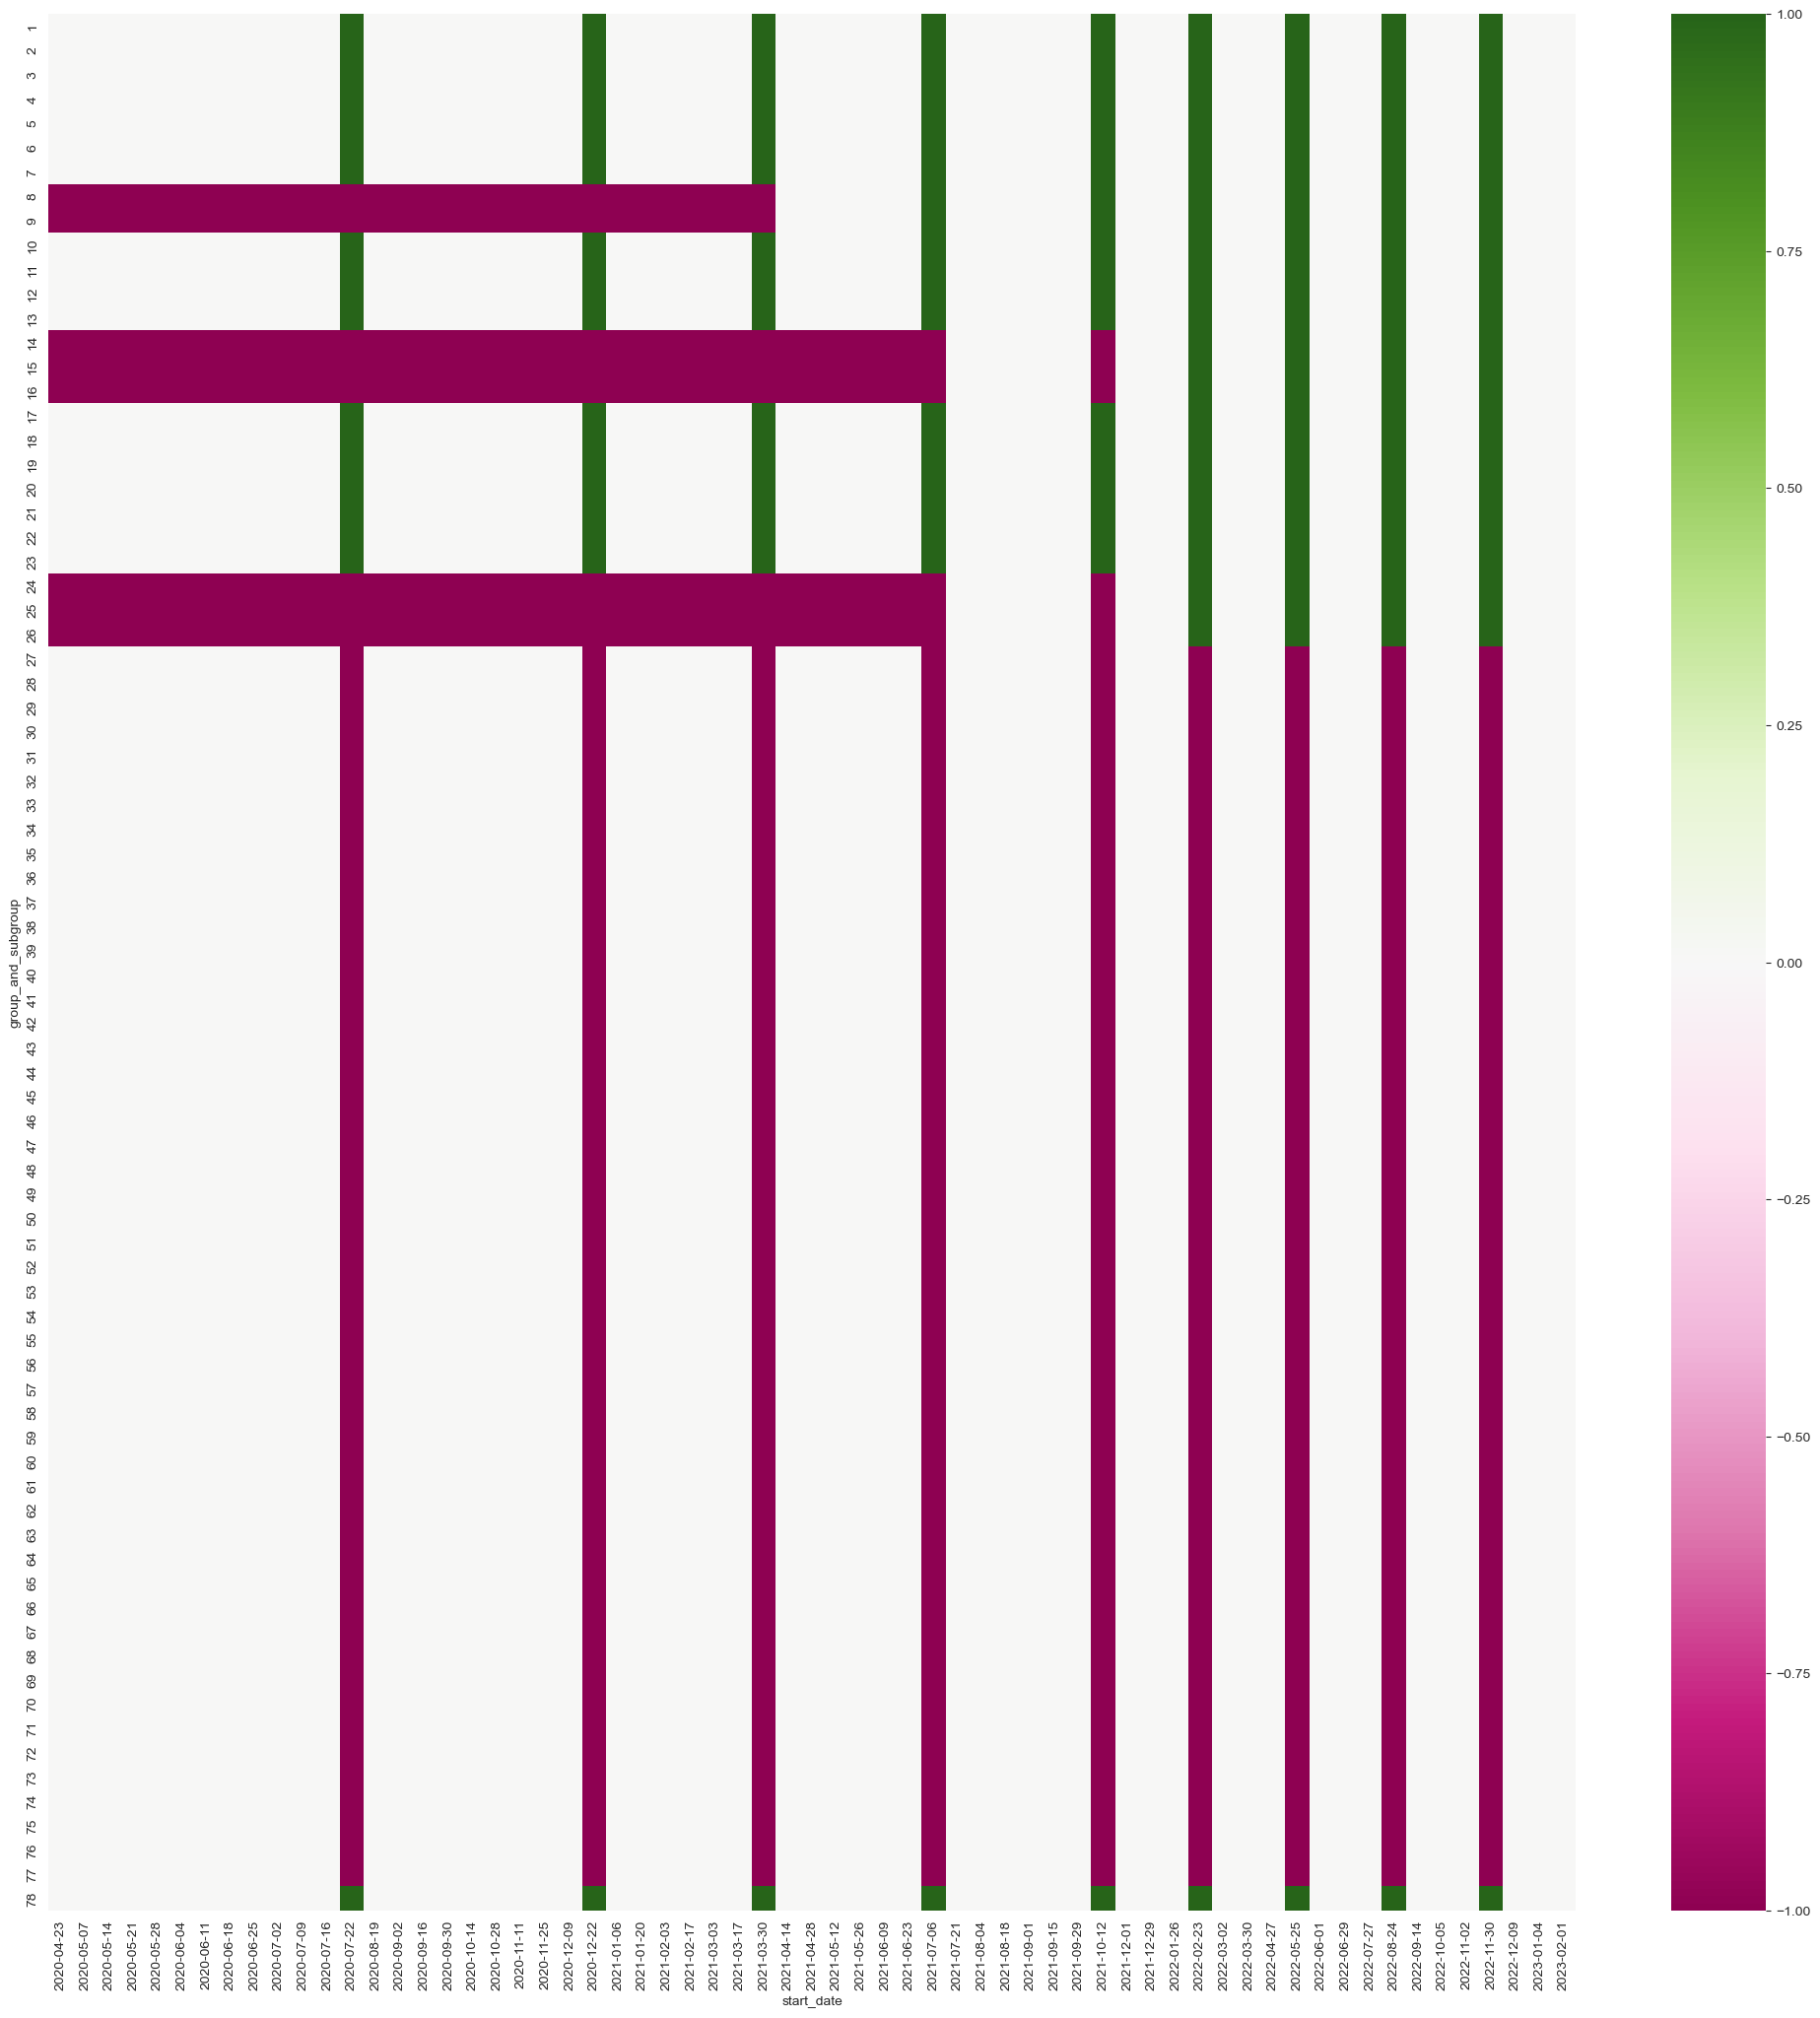

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(25, 25))

sns.heatmap(data, annot=False, ax=ax, cmap="PiYG")

To interpret this, those in Gray are those that contain data in a specific date. Those in pink are data that do not exist but are not indicated as such in the original dataset - effectively a null value. Those in green are indicated as null values in the dataset.

As seen in the data above, it seems like the best course of action is to simply remove the null values. The data is missing not at random but at certain dates and weeks.

Furthermore, certain categories (e.g. 8 and 9) have missing values too but can be chalked up to data not collected at the beginning of the study. Thus, it is better to leave them be.

### Removing the Null Values

An industry practice is that instead of actually deleting values from the database, we simply add a column that says if it is actually deleted. I would follow this industry practice as future researchers deserve to know what happened to the missing data.

In [48]:
cur = conn.cursor()
cur.execute("""
    ALTER TABLE cleaned_data
    ADD COLUMN is_deleted NOT NULL DEFAULT 0;
""")

In [49]:
cur = conn.cursor()
cur.execute("""
    UPDATE OR IGNORE cleaned_data
    SET is_deleted = 1
    WHERE "index" IN (
        SELECT "index"
        FROM cleaned_data
        WHERE Value IS NULL
    );
""")

In [50]:
conn.commit()

### Visualizing Missing Quartiles

In [51]:
cur = conn.cursor()
cur.execute("""
    SELECT
        group_and_subgroup,
        start_date_ISO,
        ("upper_quartile" IS NULL) AS null_vals
    FROM cleaned_data
    WHERE is_deleted = 0
    ORDER BY group_and_subgroup ASC, start_date_ISO ASC;
""")
data = pd.DataFrame(cur.fetchall(), columns=["group_and_subgroup", "start_date", "is_null"])

In [52]:
data = data.pivot_table(index="group_and_subgroup", columns="start_date", values="is_null").fillna(-1)
data

start_date,2020-04-23,2020-05-07,2020-05-14,2020-05-21,2020-05-28,2020-06-04,2020-06-11,2020-06-18,2020-06-25,2020-07-02,...,2022-04-27,2022-06-01,2022-06-29,2022-07-27,2022-09-14,2022-10-05,2022-11-02,2022-12-09,2023-01-04,2023-02-01
group_and_subgroup,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:xlabel='start_date', ylabel='group_and_subgroup'>

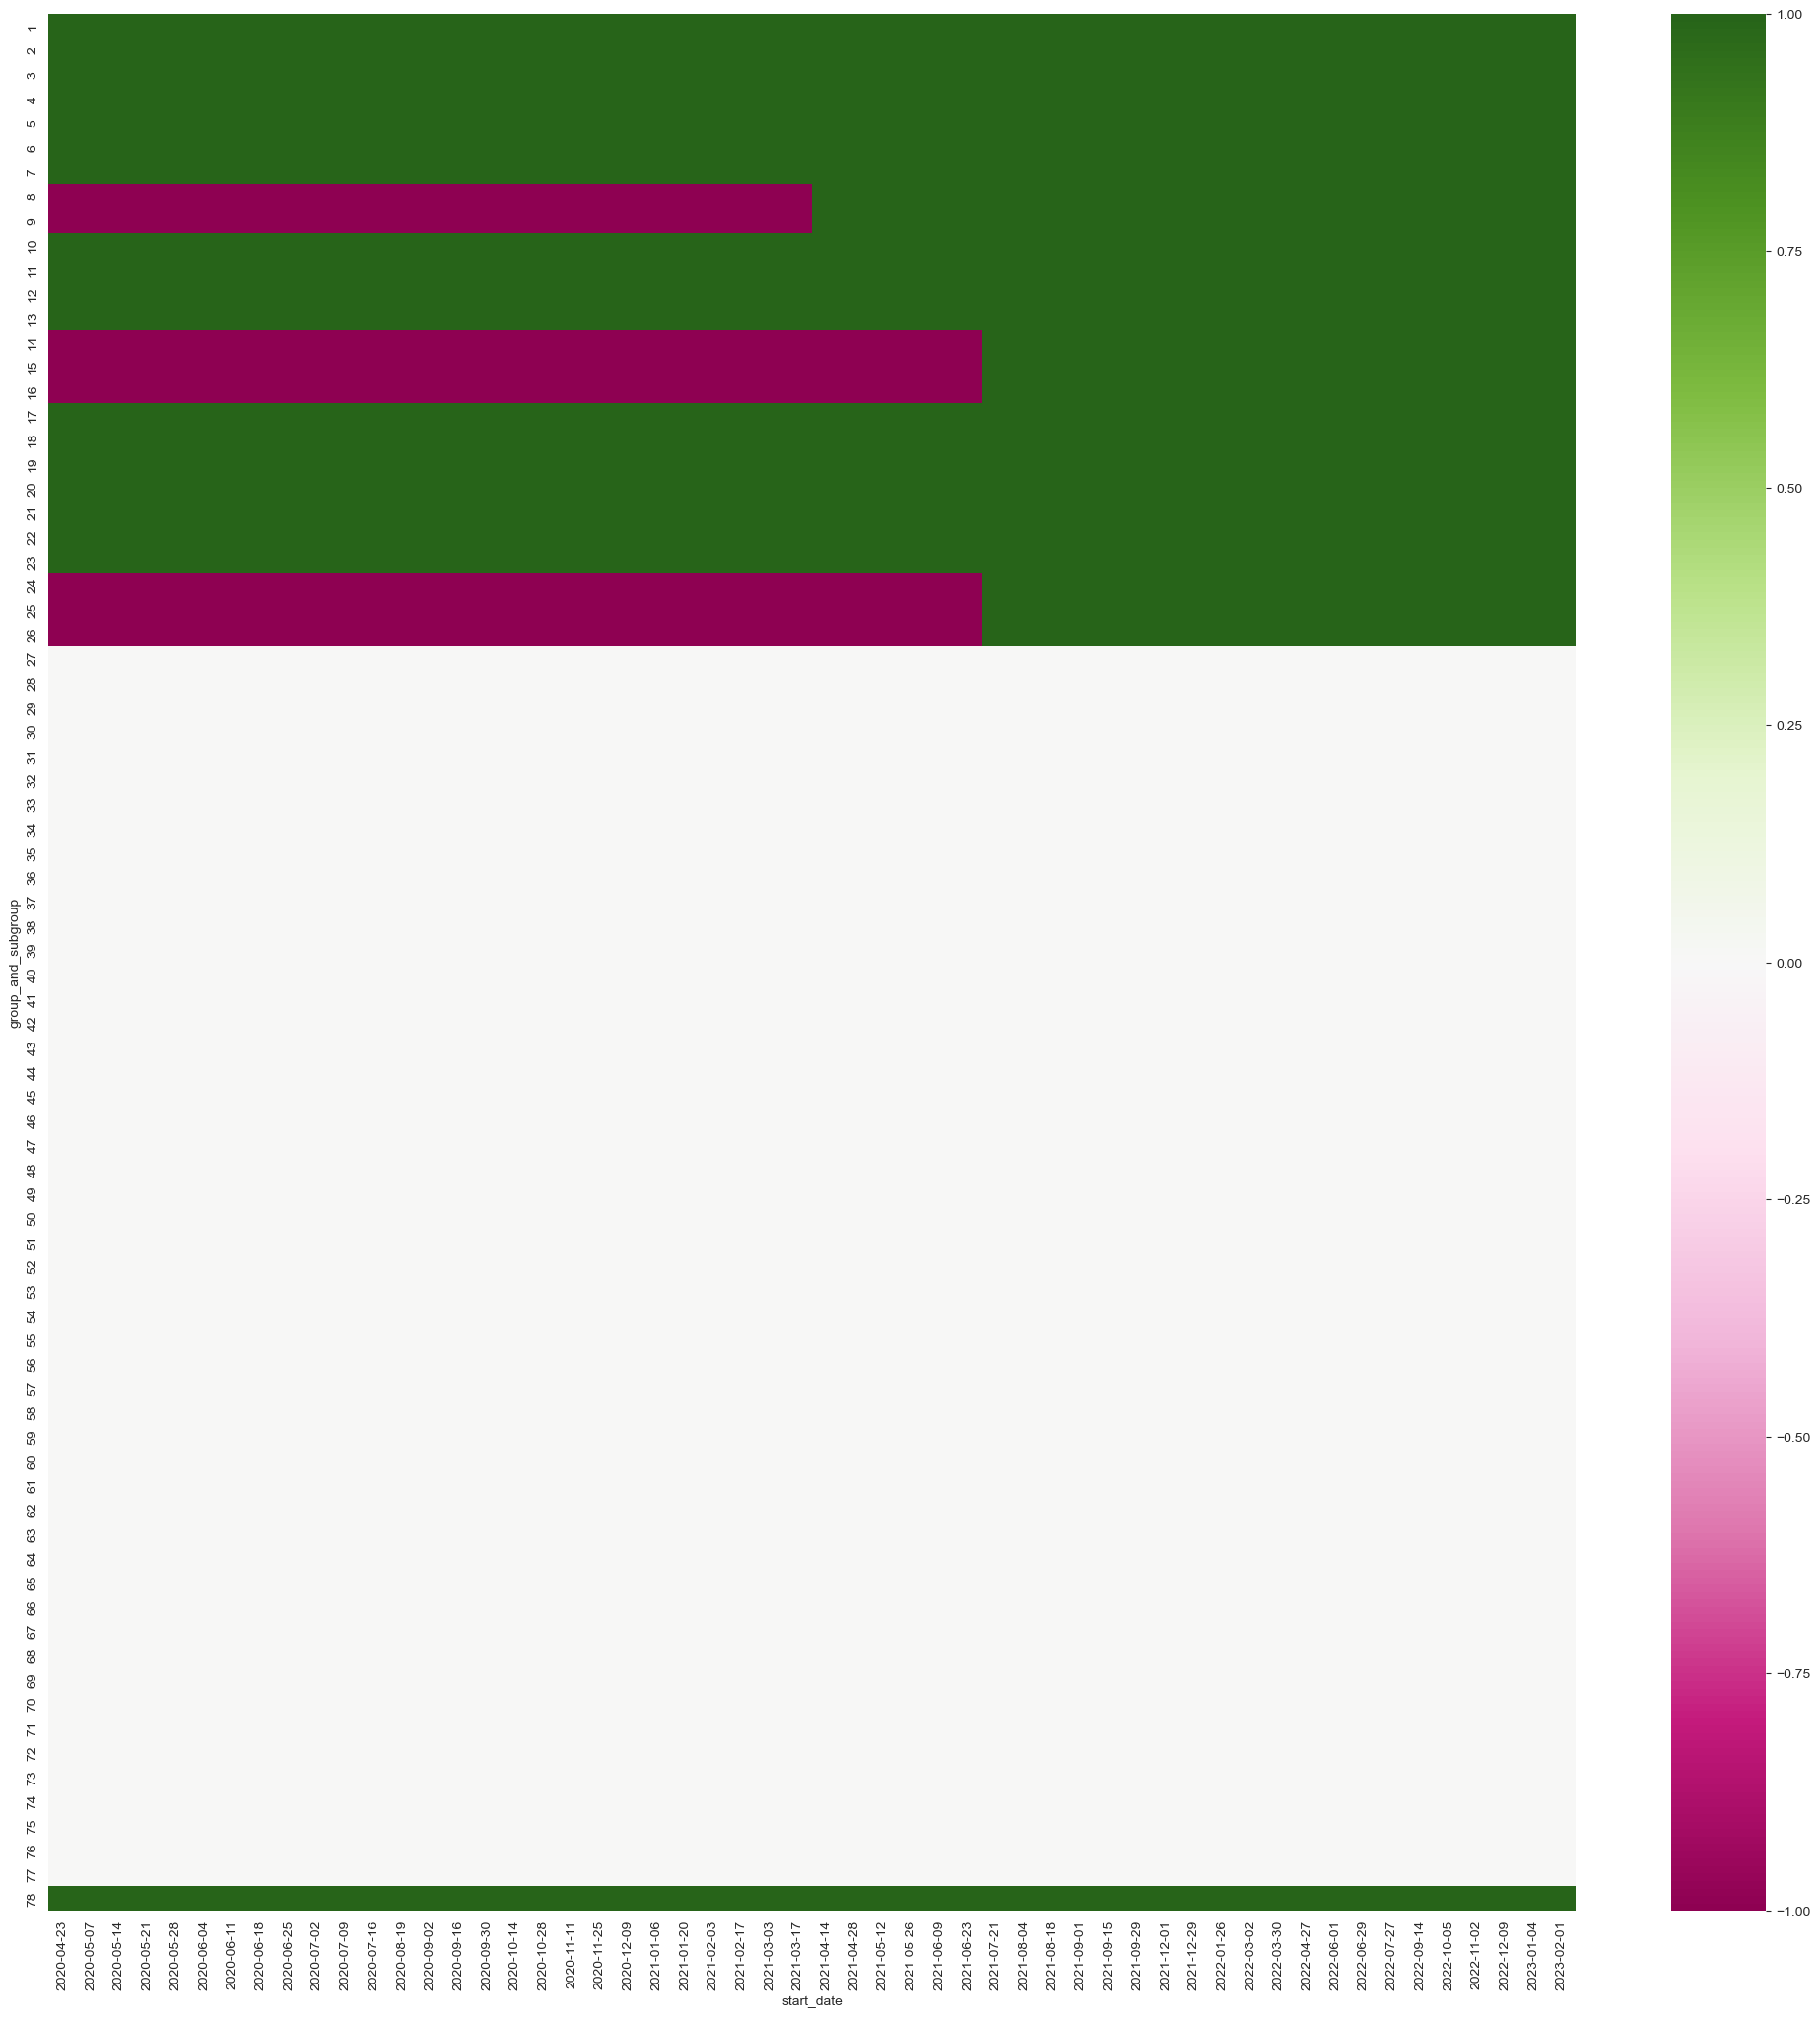

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(25, 25))

sns.heatmap(data, annot=False, ax=ax, cmap="PiYG")

With this finding, it is better to simply leave the data as is. With this finding, it could indicate that the quartiles simply do not make sense for certain categories. This is better documented rather than us filling the missing the null values.

## Creating a View

With the many updates we did, it is better for us to create a view so that the data looks cleaner and has a better format.

In [54]:
cur = conn.cursor()
cur.execute("""
    CREATE TEMP VIEW IF NOT EXISTS cleaned_data_view
    AS SELECT
        state_code,
        group_and_subgroup,
        start_date_ISO AS start_date,
        end_date_ISO AS end_date,
        Value as datapoint,
        "Low CI" as lower_ci,
        "High CI" as upper_ci,
        lower_quartile,
        upper_quartile,
        symptoms_depressive,
        symptoms_anxiety
    FROM cleaned_data
    WHERE is_deleted = 0;
""")

In [55]:
conn.commit()

## Exploratory Data Analysis

In [140]:
cur = conn.cursor()
cur.execute("""
    SELECT
        state_code,
        STRFTIME('%m-%Y', end_date) AS month_year,
        AVG(lower_ci) AS avg_lower_ci,
        AVG(datapoint) AS avg_datapoint,
        AVG(upper_ci) AS avg_upper_ci
    FROM cleaned_data_view
    WHERE group_and_subgroup >= 27 AND symptoms_anxiety AND NOT symptoms_depressive
    GROUP BY state_code, STRFTIME('%m-%Y', end_date)
    ORDER BY state_code ASC, STRFTIME('%Y-%m', end_date) ASC;
""")
data = pd.DataFrame(cur.fetchall(), columns=["state_code", "end_date", "lower_ci", "datapoint", "higher_ci"])

In [141]:
data.head()

,state_code,end_date,lower_ci,datapoint,higher_ci
0,AK,05-2020,24.15,28.225000,32.575
1,AK,06-2020,25.50,29.980000,34.760
2,AK,07-2020,27.10,32.066667,37.300
3,AK,08-2020,27.50,30.500000,33.500
4,AK,09-2020,26.35,29.150000,32.050


In [146]:
colors = data['state_code'].unique().copy()
colors = pd.DataFrame(colors, columns=['state_code'])
colors['color'] = colors['state_code'].apply(lambda item: 'blue' if item == 'US' else 'gray')
colors

,state_code,color
0,AK,gray
1,AL,gray
2,AR,gray
3,AZ,gray
4,CA,gray
5,CO,gray
6,CT,gray
7,DC,gray
8,DE,gray
9,FL,gray


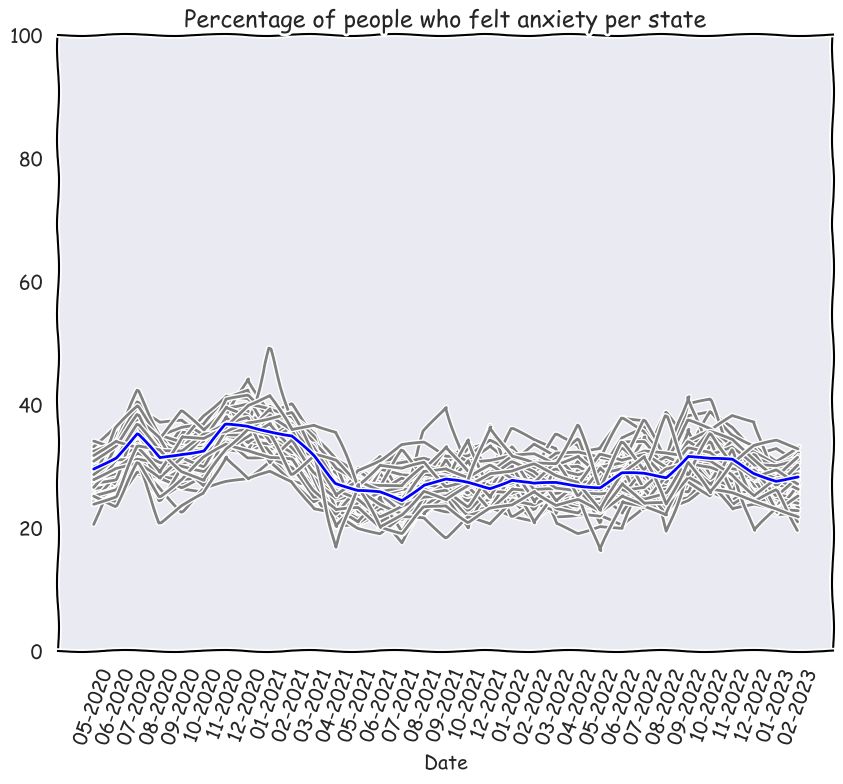

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.ylim(0, 100)
plt.xlabel("Date")
plt.title("Percentage of people who felt anxiety per state")
plt.xticks(rotation=70)
plt.xkcd()

for index, item in colors.iterrows():
    state, color = item['state_code'], item['color']
    datum = data[data['state_code'] == state]

    x = datum['end_date']
    y = datum['datapoint']

    zorder = 100 if state == 'US' else 0

    ax.plot(x, y, color=color, zorder=zorder)

In [153]:
cur = conn.cursor()
cur.execute("""
    SELECT
        state_code,
        STRFTIME('%m-%Y', end_date) AS month_year,
        AVG(lower_ci) AS avg_lower_ci,
        AVG(datapoint) AS avg_datapoint,
        AVG(upper_ci) AS avg_upper_ci
    FROM cleaned_data_view
    WHERE group_and_subgroup >= 27 AND NOT symptoms_anxiety AND symptoms_depressive
    GROUP BY state_code, STRFTIME('%m-%Y', end_date)
    ORDER BY state_code ASC, STRFTIME('%Y-%m', end_date) ASC;
""")
data = pd.DataFrame(cur.fetchall(), columns=["state_code", "end_date", "lower_ci", "datapoint", "higher_ci"])

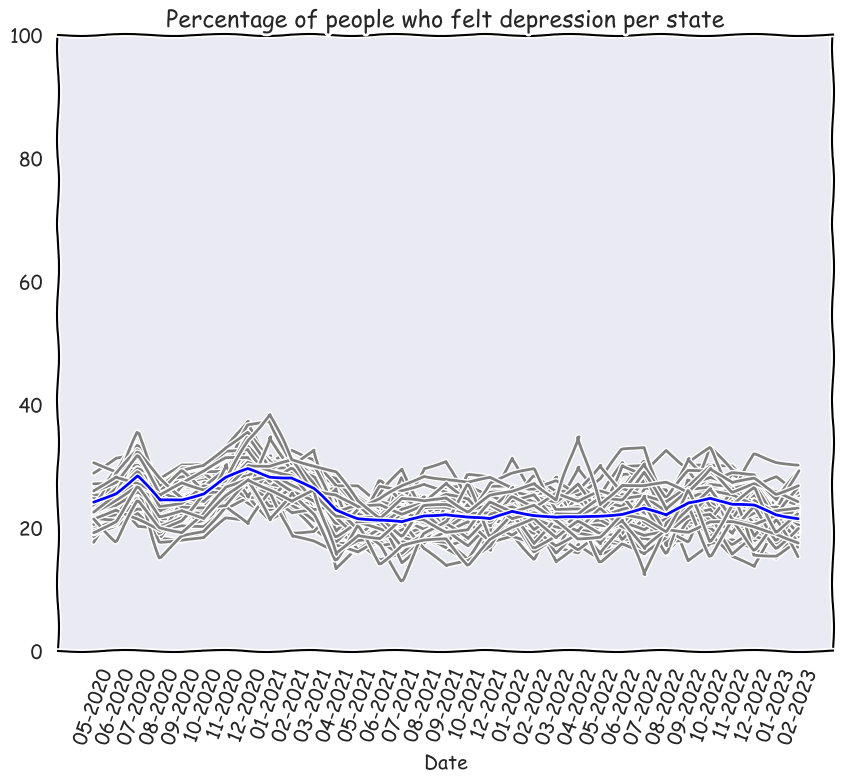

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.ylim(0, 100)
plt.xlabel("Date")
plt.title("Percentage of people who felt depression per state")
plt.xticks(rotation=70)
plt.xkcd()

for index, item in colors.iterrows():
    state, color = item['state_code'], item['color']
    datum = data[data['state_code'] == state]

    x = datum['end_date']
    y = datum['datapoint']

    zorder = 100 if state == 'US' else 0

    ax.plot(x, y, color=color, zorder=zorder)

## Conclusion